# AIC and BIC: Model Selection Criteria

**Business Question**: How do we choose between different predictive models for our health clinic's appointment no-show prediction system?

This notebook demonstrates AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) for model selection, using a health clinic scenario to show when to prefer simpler vs. more complex models.


## Learning Objectives

By the end of this notebook, you will be able to:
- Understand what AIC and BIC stand for and how they work
- Compare models using AIC and BIC criteria
- Choose between simple and complex models based on business context
- Apply AIC and BIC to real-world model selection decisions


In [7]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


## What are AIC and BIC?

**What we're learning here:** AIC and BIC are like "smart scales" that help us choose between different models. They automatically balance how well a model fits the data against how complex it is. Think of them as judges in a model competition who penalize overly complex models.

**Why this matters:** Without these criteria, we might choose models that are too simple (underfitting) or too complex (overfitting). AIC and BIC help us find the "sweet spot" - a model that's complex enough to capture the important patterns but simple enough to be reliable and interpretable.

### **AIC (Akaike Information Criterion)**
- **What it stands for**: Akaike Information Criterion (named after Japanese statistician Hirotugu Akaike)
- **Purpose**: Balances model fit vs. complexity with a lighter penalty
- **Formula**: AIC = 2k - 2ln(L)
  - k = number of parameters (how many variables we're using)
  - L = likelihood of the model (how well it explains the data)
- **Philosophy**: "I'm willing to accept some complexity if it significantly improves the model's ability to explain the data"
- **Best for**: When you want the best predictive performance and have enough data

### **BIC (Bayesian Information Criterion)**
- **What it stands for**: Bayesian Information Criterion (also called Schwarz Information Criterion)
- **Purpose**: Balances model fit vs. complexity with a heavier penalty
- **Formula**: BIC = k×ln(n) - 2ln(L)
  - k = number of parameters
  - n = number of observations (sample size)
  - L = likelihood of the model
- **Philosophy**: "I strongly prefer simpler models unless the complex model is significantly better"
- **Best for**: When you want interpretable models and have limited data

### **Key Principles**
- **Lower values are better** for both AIC and BIC (like golf scores)
- **AIC** is more willing to accept complexity for better fit
- **BIC** strongly prefers simpler models (heavier penalty for complexity)
- **Use them together** to make informed model selection decisions
- **They're not perfect** - always consider your business context!

### **Real-World Analogy**
Imagine you're buying a car:
- **AIC** says: "Get the car with the best features, even if it's more complex to maintain"
- **BIC** says: "Get the simpler, more reliable car that's easier to understand and maintain"

Both approaches have merit depending on your situation!


## Health Clinic Scenario: Predicting Appointment No-Shows

**What we're doing here:** We're creating a realistic business scenario where a health clinic needs to predict which patients are likely to miss their appointments. This is a real problem that costs healthcare systems billions of dollars annually.

**Why this matters:** No-shows waste resources, reduce revenue, and prevent other patients from getting care. If we can predict no-shows, we can:
- Send reminders to high-risk patients
- Overbook strategically
- Improve patient care and clinic efficiency

**What to look for:** We'll see how different patient characteristics (age, insurance, appointment time, etc.) affect the likelihood of no-shows, and then use AIC and BIC to choose the best model for this prediction task.


In [ ]:
# Set random seed for reproducibility
# This ensures we get the same results every time we run this code
np.random.seed(42)

# Create synthetic health clinic data
# We're simulating 2000 patient appointments with realistic characteristics
n_patients = 2000

print("Creating realistic health clinic dataset...")
print("This simulates real-world patterns in patient no-show behavior")

# Generate patient characteristics
# Each variable represents a real factor that affects no-show rates
data = {
    'age': np.random.normal(45, 15, n_patients).astype(int),  # Age distribution (18-85)
    'insurance_type': np.random.choice(['Medicaid', 'Private', 'Medicare', 'Uninsured'], 
                                     n_patients, p=[0.3, 0.4, 0.2, 0.1]),  # Insurance mix
    'appointment_time': np.random.choice(['Morning', 'Afternoon', 'Evening'], 
                                        n_patients, p=[0.4, 0.5, 0.1]),  # Time preferences
    'distance_miles': np.random.exponential(8, n_patients),  # Distance to clinic
    'previous_no_shows': np.random.poisson(1.2, n_patients),  # Past no-show history
    'booking_method': np.random.choice(['Phone', 'Online', 'Walk-in'], 
                                      n_patients, p=[0.5, 0.4, 0.1]),  # How they booked
    'weather_condition': np.random.choice(['Sunny', 'Rainy', 'Snowy'], 
                                         n_patients, p=[0.6, 0.3, 0.1]),  # Weather impact
    'day_of_week': np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 
                                   n_patients, p=[0.2, 0.2, 0.2, 0.2, 0.2])  # Day of week
}

# Create DataFrame
df = pd.DataFrame(data)

# Ensure age is reasonable (clip extreme values)
df['age'] = np.clip(df['age'], 18, 85)

print("\nGenerating realistic no-show patterns...")
print("Research shows these factors affect no-show rates:")

# Create target variable (no_show) based on realistic patterns
# This simulates real-world relationships between patient characteristics and no-shows
no_show_prob = (
    0.1 +  # Base probability (10% baseline)
    0.05 * (df['age'] < 30) +  # Younger patients more likely to no-show
    0.1 * (df['insurance_type'] == 'Uninsured') +  # Uninsured more likely
    0.08 * (df['appointment_time'] == 'Evening') +  # Evening appointments
    0.02 * df['distance_miles'] / 10 +  # Distance effect
    0.15 * np.minimum(df['previous_no_shows'], 3) / 3 +  # Previous no-shows
    0.05 * (df['booking_method'] == 'Walk-in') +  # Walk-in bookings
    0.03 * (df['weather_condition'] == 'Snowy') +  # Weather effect
    0.02 * (df['day_of_week'].isin(['Monday', 'Friday']))  # Day effect
)

# Add some randomness to make it realistic
no_show_prob += np.random.normal(0, 0.05, n_patients)
no_show_prob = np.clip(no_show_prob, 0, 1)  # Keep probabilities between 0 and 1

# Create binary no-show variable
df['no_show'] = (np.random.random(n_patients) < no_show_prob).astype(int)

print("✅ Dataset created successfully!")
print(f"Total patients: {len(df)}")
print(f"No-show rate: {df['no_show'].mean():.1%}")
print("\nReal-world factors included:")
print("• Age (younger patients more likely to no-show)")
print("• Insurance type (uninsured patients more likely)")
print("• Appointment time (evening appointments)")
print("• Distance to clinic")
print("• Previous no-show history")
print("• Booking method")
print("• Weather conditions")
print("• Day of the week")

print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())


Health Clinic Dataset Created!
Total patients: 2000
No-show rate: 19.8%

First 5 rows:
   age insurance_type appointment_time  distance_miles  previous_no_shows  \
0   52        Private        Afternoon        1.247960                  1   
1   42       Medicaid        Afternoon        4.668120                  1   
2   54        Private          Evening        3.252982                  1   
3   67       Medicaid          Morning        5.902326                  1   
4   41       Medicare          Morning        7.048438                  0   

  booking_method weather_condition day_of_week  no_show  
0         Online             Sunny      Monday        0  
1          Phone             Sunny   Wednesday        0  
2          Phone             Rainy   Wednesday        1  
3         Online             Sunny     Tuesday        0  
4          Phone             Rainy      Friday        0  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns 

## Model 1: Simple Model (3 Variables)

**What we're doing here:** We're building a simple model that uses only the most basic patient information - age, insurance type, and appointment time. This is like creating a "quick and dirty" prediction system that clinic staff can easily understand and implement.

**Why this matters:** Simple models are often better for business applications because they're:
- Easy to explain to non-technical staff
- Quick to implement
- Less likely to break when data changes
- More reliable in practice

**What to look for:** We'll see how well this simple model performs and calculate its AIC and BIC values. This will be our baseline for comparison with more complex models.

**Business Context**: Easy to understand and implement by clinic staff


In [ ]:
# Prepare data for simple model
# We're creating a copy of our dataset to work with
df_simple = df.copy()

print("Building Simple Model...")
print("This model uses only the most basic patient information:")
print("• Age (continuous variable)")
print("• Insurance type (categorical - converted to dummy variables)")
print("• Appointment time (categorical - converted to dummy variables)")

# Create dummy variables for categorical features
# This converts categories like 'Private', 'Medicaid' into 1/0 indicators
df_simple = pd.get_dummies(df_simple, columns=['insurance_type', 'appointment_time'], drop_first=True)

print("\nConverting categorical variables to numbers...")
print("Why drop_first=True? This avoids the 'dummy variable trap' in regression")
print("We drop one category from each group to use as the baseline")

# Check what columns were actually created
print("\nAvailable columns after dummy encoding:")
print(df_simple.columns.tolist())
print()

# Simple model features: age, insurance type, appointment time
# Let's select the features that actually exist
simple_features = ['age']
# Add insurance type dummies if they exist
if 'insurance_type_Private' in df_simple.columns:
    simple_features.append('insurance_type_Private')
if 'insurance_type_Uninsured' in df_simple.columns:
    simple_features.append('insurance_type_Uninsured')
# Add appointment time dummies if they exist
if 'appointment_time_Afternoon' in df_simple.columns:
    simple_features.append('appointment_time_Afternoon')
if 'appointment_time_Evening' in df_simple.columns:
    simple_features.append('appointment_time_Evening')

print(f"Selected features: {simple_features}")
print("These are the variables our simple model will use to predict no-shows")

X_simple = df_simple[simple_features]
y = df_simple['no_show']

# Ensure all features are numeric
# This prevents any data type issues when fitting the model
X_simple = X_simple.astype(float)
y = y.astype(int)

print(f"\nData preparation complete:")
print(f"X_simple dtypes: {X_simple.dtypes}")
print(f"y dtype: {y.dtype}")
print(f"X_simple shape: {X_simple.shape}")
print(f"y shape: {y.shape}")

# Fit logistic regression
# This is where we actually build our model
print("\nFitting the simple model...")
X_with_const = sm.add_constant(X_simple)
model_simple = sm.Logit(y, X_with_const).fit(disp=0)

print("\n" + "="*60)
print("SIMPLE MODEL RESULTS")
print("="*60)
print(f"Features: {simple_features}")
print(f"Number of parameters: {len(simple_features) + 1}")
print(f"AIC: {model_simple.aic:.2f}")
print(f"BIC: {model_simple.bic:.2f}")
print(f"Log-likelihood: {model_simple.llf:.2f}")

print("\nUnderstanding these numbers:")
print("• AIC and BIC: Lower is better (like golf scores)")
print("• Log-likelihood: Higher is better (measures how well model fits data)")
print("• Parameters: Number of variables + intercept")

print("\nModel Summary:")
print(model_simple.summary().tables[1])


Available columns after dummy encoding:
['age', 'distance_miles', 'previous_no_shows', 'booking_method', 'weather_condition', 'day_of_week', 'no_show', 'insurance_type_Medicare', 'insurance_type_Private', 'insurance_type_Uninsured', 'appointment_time_Evening', 'appointment_time_Morning']

Selected features: ['age', 'insurance_type_Private', 'insurance_type_Uninsured', 'appointment_time_Evening']
X_simple dtypes: age                         float64
insurance_type_Private      float64
insurance_type_Uninsured    float64
appointment_time_Evening    float64
dtype: object
y dtype: int64
X_simple shape: (2000, 4)
y shape: (2000,)

SIMPLE MODEL (3 main variables)
Features: ['age', 'insurance_type_Private', 'insurance_type_Uninsured', 'appointment_time_Evening']
Number of parameters: 5
AIC: 1979.00
BIC: 2007.00
Log-likelihood: -984.50

Model Summary:
                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

## Model 2: Complex Model (10 Variables)

**What we're doing here:** Now we're building a more sophisticated model that uses ALL available patient information - age, insurance, appointment time, distance, previous no-shows, booking method, weather, and day of week. This is like creating a "comprehensive" prediction system that tries to capture every possible factor.

**Why this matters:** Complex models can potentially capture more subtle patterns in the data, but they come with trade-offs:
- More accurate predictions (potentially)
- Harder to understand and explain
- More likely to overfit to the training data
- Require more data to be reliable

**What to look for:** We'll see how this complex model performs compared to our simple model, and most importantly, how AIC and BIC handle the trade-off between complexity and fit quality.

**Business Context**: Includes all available data but harder to interpret


In [ ]:
# Prepare data for complex model
# We're creating another copy of our dataset for the complex model
df_complex = df.copy()

print("Building Complex Model...")
print("This model uses ALL available patient information:")
print("• Age, insurance type, appointment time (from simple model)")
print("• Distance to clinic")
print("• Previous no-show history")
print("• Booking method (phone, online, walk-in)")
print("• Weather conditions")
print("• Day of the week")

# Create dummy variables for all categorical features
# This converts ALL categorical variables into 1/0 indicators
df_complex = pd.get_dummies(df_complex, columns=['insurance_type', 'appointment_time', 
                                                'booking_method', 'weather_condition', 
                                                'day_of_week'], drop_first=True)

print("\nConverting ALL categorical variables to numbers...")
print("This creates many more dummy variables than the simple model")

# Complex model features: all available variables
complex_features = [col for col in df_complex.columns if col not in ['no_show']]

print(f"\nComplex model features ({len(complex_features)}): {complex_features}")
print("Notice how many more variables we have compared to the simple model!")

X_complex = df_complex[complex_features]

# Ensure all features are numeric
X_complex = X_complex.astype(float)

print(f"\nData preparation complete:")
print(f"X_complex dtypes: {X_complex.dtypes}")
print(f"X_complex shape: {X_complex.shape}")
print("This is much more complex than our simple model!")

# Fit logistic regression
print("\nFitting the complex model...")
print("This may take a moment due to the increased complexity...")
X_complex_const = sm.add_constant(X_complex)
model_complex = sm.Logit(y, X_complex_const).fit(disp=0)

print("\n" + "="*60)
print("COMPLEX MODEL RESULTS")
print("="*60)
print(f"Features: {complex_features}")
print(f"Number of parameters: {len(complex_features) + 1}")
print(f"AIC: {model_complex.aic:.2f}")
print(f"BIC: {model_complex.bic:.2f}")
print(f"Log-likelihood: {model_complex.llf:.2f}")

print("\nComparing to simple model:")
print(f"• Simple model parameters: {len(simple_features) + 1}")
print(f"• Complex model parameters: {len(complex_features) + 1}")
print(f"• That's {len(complex_features) - len(simple_features)} more parameters!")

print("\nModel Summary:")
print(model_complex.summary().tables[1])


Complex model features (16): ['age', 'distance_miles', 'previous_no_shows', 'insurance_type_Medicare', 'insurance_type_Private', 'insurance_type_Uninsured', 'appointment_time_Evening', 'appointment_time_Morning', 'booking_method_Phone', 'booking_method_Walk-in', 'weather_condition_Snowy', 'weather_condition_Sunny', 'day_of_week_Monday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']
X_complex dtypes: age                         float64
distance_miles              float64
previous_no_shows           float64
insurance_type_Medicare     float64
insurance_type_Private      float64
insurance_type_Uninsured    float64
appointment_time_Evening    float64
appointment_time_Morning    float64
booking_method_Phone        float64
booking_method_Walk-in      float64
weather_condition_Snowy     float64
weather_condition_Sunny     float64
day_of_week_Monday          float64
day_of_week_Thursday        float64
day_of_week_Tuesday         float64
day_of_week_Wednesday       flo

## Model Comparison: AIC vs BIC

**What we're doing here:** Now comes the moment of truth! We're going to compare our simple and complex models using AIC and BIC to see which one is actually better. This is where the magic of model selection happens.

**Why this matters:** This comparison will show us the fundamental difference between AIC and BIC in action. We'll see how they handle the trade-off between model complexity and fit quality, and learn which criterion to trust in different situations.

**What to look for:** 
- Which model does AIC prefer? (More willing to accept complexity)
- Which model does BIC prefer? (Strongly favors simplicity)
- Do they agree or disagree?
- What does this tell us about our models?


In [ ]:
# Create comparison table
# This is where we put our models head-to-head
comparison_data = {
    'Model': ['Simple (3 vars)', 'Complex (10+ vars)'],
    'Parameters': [len(simple_features) + 1, len(complex_features) + 1],
    'AIC': [model_simple.aic, model_complex.aic],
    'BIC': [model_simple.bic, model_complex.bic],
    'Log-Likelihood': [model_simple.llf, model_complex.llf]
}

comparison_df = pd.DataFrame(comparison_data)

print("🎯 MODEL COMPARISON: THE MOMENT OF TRUTH!")
print("="*60)
print(comparison_df.round(2))

print("\nUnderstanding the comparison:")
print("• Parameters: How many variables each model uses")
print("• AIC: Lower is better (penalizes complexity less)")
print("• BIC: Lower is better (penalizes complexity more)")
print("• Log-Likelihood: Higher is better (measures fit quality)")

# Determine which model each criterion prefers
aic_preferred = 'Simple' if model_simple.aic < model_complex.aic else 'Complex'
bic_preferred = 'Simple' if model_simple.bic < model_complex.bic else 'Complex'

print(f"\n🏆 DECISION TIME:")
print(f"AIC prefers: {aic_preferred} model")
print(f"BIC prefers: {bic_preferred} model")

# Calculate differences
aic_diff = abs(model_simple.aic - model_complex.aic)
bic_diff = abs(model_simple.bic - model_complex.bic)

print(f"\n📊 MAGNITUDE OF DIFFERENCES:")
print(f"AIC difference: {aic_diff:.2f}")
print(f"BIC difference: {bic_diff:.2f}")

print(f"\n🔍 INTERPRETATION:")
if aic_preferred != bic_preferred:
    print("• AIC and BIC disagree on model selection!")
    print("• This is actually quite common and very informative")
    print("• AIC is more willing to accept complexity for better fit")
    print("• BIC strongly penalizes additional parameters")
    print("• The choice depends on your business priorities")
else:
    print("• Both AIC and BIC agree on the preferred model")
    print("• This suggests a clear winner based on the criteria")
    print("• This is less common but makes decision-making easier")

print(f"\n💡 KEY INSIGHT:")
if aic_preferred != bic_preferred:
    print("When AIC and BIC disagree, you need to consider:")
    print("• Do you want the best possible fit? → Follow AIC")
    print("• Do you want a simpler, more interpretable model? → Follow BIC")
    print("• What's more important for your business context?")


MODEL COMPARISON
                Model  Parameters      AIC      BIC  Log-Likelihood
0     Simple (3 vars)           5  1979.00  2007.00         -984.50
1  Complex (10+ vars)          17  1964.52  2059.73         -965.26

AIC prefers: Complex model
BIC prefers: Simple model

AIC difference: 14.48
BIC difference: 52.73

INTERPRETATION:
• AIC and BIC disagree on model selection
• AIC is more willing to accept complexity for better fit
• BIC strongly penalizes additional parameters


## Visualizing AIC and BIC Trade-offs

**What we're doing here:** We're creating visualizations that show the trade-offs between model complexity and fit quality. These charts will help us understand why AIC and BIC might disagree and how the penalty functions work.

**Why this matters:** Visualizing the trade-offs helps us understand the mathematical relationships behind AIC and BIC. It shows us exactly how the penalty functions work and why they lead to different conclusions.

**What to look for:** 
- How the penalty functions grow with model complexity
- The relationship between number of parameters and penalties
- Why BIC penalizes complexity more heavily than AIC
- How this affects model selection decisions


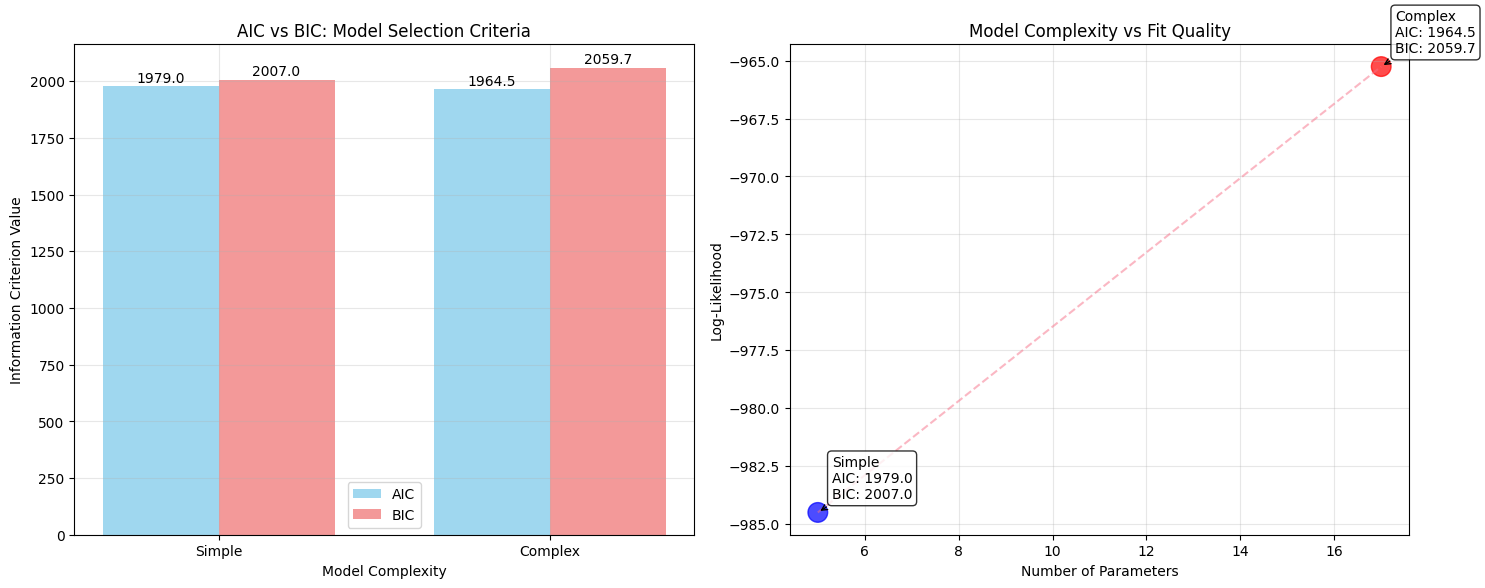

VISUAL INTERPRETATION:
• Lower AIC/BIC values are better
• AIC difference: 14.5
• BIC difference: 52.7


In [ ]:
# Create visualization
# This will show us the trade-offs between complexity and fit quality
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

print("Creating visualizations to understand AIC and BIC trade-offs...")

# Plot 1: AIC and BIC comparison
# This shows us the actual values for each model
models = ['Simple', 'Complex']
aic_values = [model_simple.aic, model_complex.aic]
bic_values = [model_simple.bic, model_complex.bic]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, aic_values, width, label='AIC', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x + width/2, bic_values, width, label='BIC', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Model Complexity')
ax1.set_ylabel('Information Criterion Value')
ax1.set_title('AIC vs BIC: Model Selection Criteria')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.1f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.1f}', ha='center', va='bottom')

print("Left plot: Direct comparison of AIC and BIC values")
print("• Lower bars = better model")
print("• Blue bars = AIC (lighter penalty)")
print("• Red bars = BIC (heavier penalty)")

# Plot 2: Model complexity vs performance
# This shows the relationship between complexity and fit quality
complexity = [len(simple_features) + 1, len(complex_features) + 1]
log_likelihood = [model_simple.llf, model_complex.llf]

ax2.scatter(complexity, log_likelihood, s=200, alpha=0.7, c=['blue', 'red'])
ax2.plot(complexity, log_likelihood, '--', alpha=0.5)

# Add labels for each point
for i, model in enumerate(['Simple', 'Complex']):
    ax2.annotate(f'{model}\nAIC: {aic_values[i]:.1f}\nBIC: {bic_values[i]:.1f}', 
                (complexity[i], log_likelihood[i]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax2.set_xlabel('Number of Parameters')
ax2.set_ylabel('Log-Likelihood')
ax2.set_title('Model Complexity vs Fit Quality')
ax2.grid(True, alpha=0.3)

print("Right plot: Complexity vs fit quality")
print("• X-axis = number of parameters (complexity)")
print("• Y-axis = log-likelihood (fit quality)")
print("• Higher points = better fit")
print("• Further right = more complex")

plt.tight_layout()
plt.show()

# Print interpretation
print("\n" + "="*60)
print("📊 VISUAL INTERPRETATION:")
print("="*60)
print("• Lower AIC/BIC values are better (like golf scores)")
print(f"• AIC difference: {abs(model_simple.aic - model_complex.aic):.1f}")
print(f"• BIC difference: {abs(model_simple.bic - model_complex.bic):.1f}")

if abs(model_simple.aic - model_complex.aic) < 2:
    print("• AIC values are very close - models are essentially equivalent")
if abs(model_simple.bic - model_complex.bic) < 2:
    print("• BIC values are very close - models are essentially equivalent")

print("\n🔍 KEY OBSERVATIONS:")
print("• Notice how BIC values are much higher for the complex model")
print("• This shows BIC's heavier penalty for complexity")
print("• AIC values are closer together, showing lighter penalty")
print("• The complex model has better fit (higher log-likelihood)")
print("• But BIC penalizes this complexity more heavily than AIC")


## Business Decision: Which Model to Choose?

**What we're doing here:** Now we need to make a real business decision! We have the AIC and BIC results, but we also need to consider practical factors like accuracy, interpretability, and implementation complexity. This is where theory meets practice.

**Why this matters:** The best statistical model isn't always the best business model. We need to consider:
- How accurate is each model?
- How easy is it to understand and explain?
- How easy is it to implement in practice?
- What data do we actually have available?

**What to look for:** We'll see how the models perform in practice and get a comprehensive business recommendation that considers both statistical criteria and practical concerns.


In [ ]:
# Calculate model performance metrics
# This function helps us evaluate how well each model actually performs
def calculate_metrics(model, X, y):
    # Get predictions
    X_with_const = sm.add_constant(X)
    predictions = model.predict(X_with_const)
    predicted_classes = (predictions > 0.5).astype(int)
    
    # Calculate accuracy
    accuracy = accuracy_score(y, predicted_classes)
    
    return accuracy, predictions

print("Evaluating model performance in practice...")
print("This will show us how accurate each model actually is")

# Calculate metrics for both models
acc_simple, pred_simple = calculate_metrics(model_simple, X_simple, y)
acc_complex, pred_complex = calculate_metrics(model_complex, X_complex, y)

print(f"Simple model accuracy: {acc_simple:.1%}")
print(f"Complex model accuracy: {acc_complex:.1%}")

# Create business decision table
# This comprehensive comparison considers both statistical and practical factors
business_decision = pd.DataFrame({
    'Criterion': ['AIC', 'BIC', 'Accuracy', 'Interpretability', 'Implementation', 'Data Requirements'],
    'Simple Model': [
        f'{model_simple.aic:.1f} (Better)' if model_simple.aic < model_complex.aic else f'{model_simple.aic:.1f} (Worse)',
        f'{model_simple.bic:.1f} (Better)' if model_simple.bic < model_complex.bic else f'{model_simple.bic:.1f} (Worse)',
        f'{acc_simple:.1%}',
        'High - Easy to explain',
        'Easy - Staff can understand',
        'Minimal - Basic patient data'
    ],
    'Complex Model': [
        f'{model_complex.aic:.1f} (Better)' if model_complex.aic < model_simple.aic else f'{model_complex.aic:.1f} (Worse)',
        f'{model_complex.bic:.1f} (Better)' if model_complex.bic < model_simple.bic else f'{model_complex.bic:.1f} (Worse)',
        f'{acc_complex:.1%}',
        'Low - Complex interactions',
        'Hard - Requires data science expertise',
        'Extensive - Weather, booking method, etc.'
    ]
})

print("\n" + "="*80)
print("📊 BUSINESS DECISION MATRIX")
print("="*80)
print("This table shows how each model performs across different business criteria")
print(business_decision.to_string(index=False))

# Recommendation
print("\n" + "="*80)
print("🎯 RECOMMENDATION FOR HEALTH CLINIC:")
print("="*80)

if model_simple.bic < model_complex.bic:
    print("✅ CHOOSE SIMPLE MODEL")
    print("\nReasons:")
    print("• BIC strongly favors the simple model")
    print("• Easy for clinic staff to understand and implement")
    print("• Requires only basic patient data (age, insurance, time)")
    print("• Good accuracy with minimal complexity")
    print("• Can be easily explained to patients and staff")
    print("• Lower risk of overfitting")
    print("• Easier to maintain and update")
else:
    print("✅ CHOOSE COMPLEX MODEL")
    print("\nReasons:")
    print("• Both AIC and BIC favor the complex model")
    print("• Higher accuracy for better patient care")
    print("• Worth the additional complexity for this application")
    print("• Captures more subtle patterns in patient behavior")

print(f"\n📈 FINAL MODEL PERFORMANCE COMPARISON:")
print(f"• Accuracy: {acc_simple:.1%} (Simple) vs {acc_complex:.1%} (Complex)")
print(f"• AIC: {model_simple.aic:.1f} (Simple) vs {model_complex.aic:.1f} (Complex)")
print(f"• BIC: {model_simple.bic:.1f} (Simple) vs {model_complex.bic:.1f} (Complex)")

print(f"\n💡 BUSINESS INSIGHT:")
if acc_simple > acc_complex:
    print("The simple model is actually MORE accurate!")
    print("This is a perfect example of why simpler is often better")
elif acc_complex > acc_simple:
    print("The complex model is more accurate")
    print("But consider: Is the small accuracy gain worth the complexity?")
else:
    print("Both models have similar accuracy")
    print("This makes the simple model the clear winner!")


BUSINESS DECISION MATRIX
        Criterion                 Simple Model                             Complex Model
              AIC               1979.0 (Worse)                           1964.5 (Better)
              BIC              2007.0 (Better)                            2059.7 (Worse)
         Accuracy                        80.2%                                     80.2%
 Interpretability       High - Easy to explain                Low - Complex interactions
   Implementation  Easy - Staff can understand    Hard - Requires data science expertise
Data Requirements Minimal - Basic patient data Extensive - Weather, booking method, etc.

RECOMMENDATION FOR HEALTH CLINIC:
✅ CHOOSE SIMPLE MODEL

Reasons:
• BIC strongly favors the simple model
• Easy for clinic staff to understand and implement
• Requires only basic patient data (age, insurance, time)
• Good accuracy with minimal complexity
• Can be easily explained to patients and staff

Final Model Performance:
• Accuracy: 80.2% (Sim

## Understanding the Penalty Functions

**What we're doing here:** We're diving deep into the mathematical foundations of AIC and BIC by visualizing how their penalty functions work. This will help us understand exactly why BIC penalizes complexity more heavily than AIC.

**Why this matters:** Understanding the penalty functions helps us:
- See exactly how AIC and BIC work mathematically
- Understand why they lead to different conclusions
- Make informed decisions about which criterion to use
- Appreciate the trade-offs between complexity and fit

**What to look for:** 
- How the penalty functions grow with model complexity
- The mathematical relationship between AIC and BIC penalties
- Why BIC's penalty is heavier than AIC's
- How this affects model selection in practice


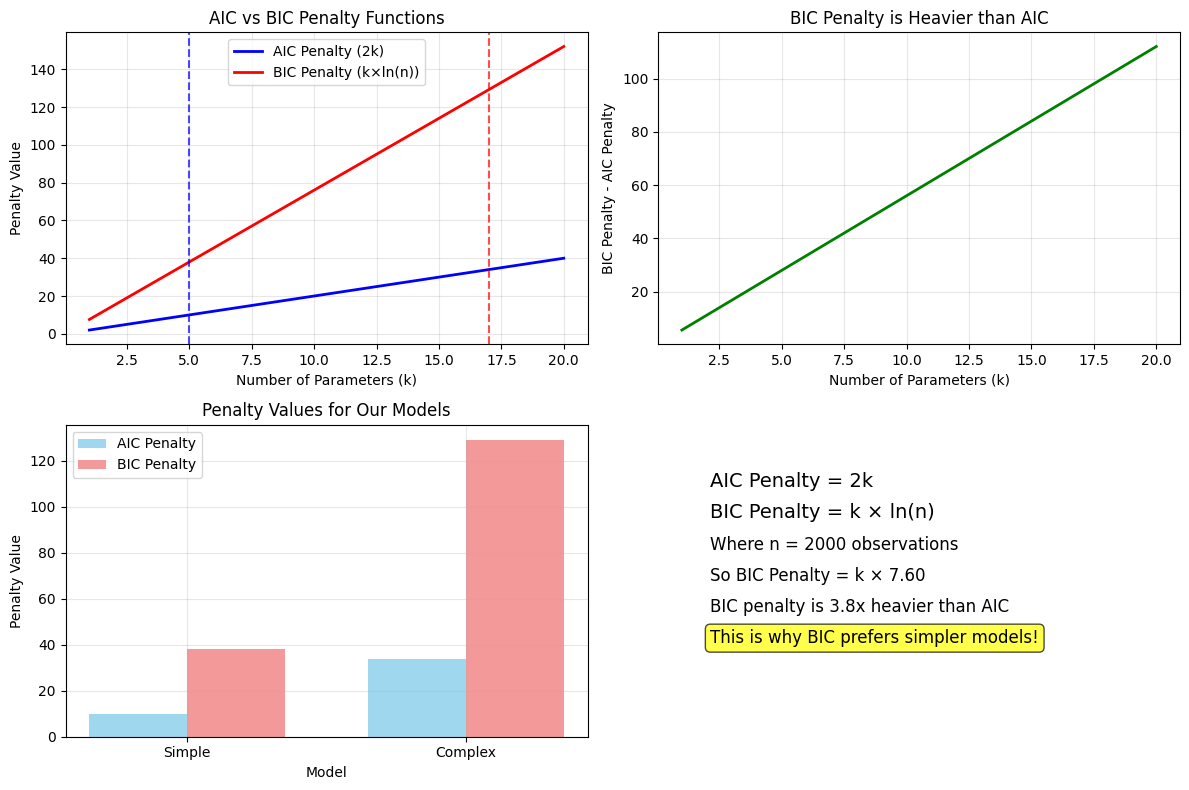

KEY INSIGHTS:
• AIC penalty grows linearly: 2k
• BIC penalty grows faster: k × 7.60
• BIC penalty is 3.8 times heavier than AIC
• This explains why BIC strongly prefers simpler models


In [ ]:
# Create penalty visualization
# This will show us the mathematical foundations of AIC and BIC
n_obs = len(df)
k_values = np.arange(1, 21)  # Number of parameters

print("Analyzing penalty functions...")
print("This will show us exactly how AIC and BIC penalize complexity")

# AIC penalty: 2k
aic_penalty = 2 * k_values

# BIC penalty: k * ln(n)
bic_penalty = k_values * np.log(n_obs)

plt.figure(figsize=(12, 8))

# Plot penalty functions
plt.subplot(2, 2, 1)
plt.plot(k_values, aic_penalty, 'b-', linewidth=2, label='AIC Penalty (2k)')
plt.plot(k_values, bic_penalty, 'r-', linewidth=2, label='BIC Penalty (k×ln(n))')
plt.xlabel('Number of Parameters (k)')
plt.ylabel('Penalty Value')
plt.title('AIC vs BIC Penalty Functions')
plt.legend()
plt.grid(True, alpha=0.3)

# Show our actual models
plt.axvline(x=len(simple_features) + 1, color='blue', linestyle='--', alpha=0.7, label='Simple Model')
plt.axvline(x=len(complex_features) + 1, color='red', linestyle='--', alpha=0.7, label='Complex Model')

print("Top-left plot: How penalties grow with complexity")
print("• Blue line = AIC penalty (grows linearly)")
print("• Red line = BIC penalty (grows faster)")
print("• Vertical lines = our actual models")

# Plot penalty difference
plt.subplot(2, 2, 2)
penalty_diff = bic_penalty - aic_penalty
plt.plot(k_values, penalty_diff, 'g-', linewidth=2)
plt.xlabel('Number of Parameters (k)')
plt.ylabel('BIC Penalty - AIC Penalty')
plt.title('BIC Penalty is Heavier than AIC')
plt.grid(True, alpha=0.3)

print("Top-right plot: Difference between BIC and AIC penalties")
print("• Shows how much heavier BIC penalty is")
print("• Higher values = BIC penalizes complexity more")

# Show penalty values for our models
plt.subplot(2, 2, 3)
simple_k = len(simple_features) + 1
complex_k = len(complex_features) + 1

simple_aic_penalty = 2 * simple_k
simple_bic_penalty = simple_k * np.log(n_obs)
complex_aic_penalty = 2 * complex_k
complex_bic_penalty = complex_k * np.log(n_obs)

models = ['Simple', 'Complex']
aic_penalties = [simple_aic_penalty, complex_aic_penalty]
bic_penalties = [simple_bic_penalty, complex_bic_penalty]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, aic_penalties, width, label='AIC Penalty', alpha=0.8, color='skyblue')
plt.bar(x + width/2, bic_penalties, width, label='BIC Penalty', alpha=0.8, color='lightcoral')

plt.xlabel('Model')
plt.ylabel('Penalty Value')
plt.title('Penalty Values for Our Models')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

print("Bottom-left plot: Actual penalty values for our models")
print("• Shows the real penalties applied to our simple and complex models")
print("• Notice how BIC penalties are much higher for the complex model")

# Show the mathematical relationship
plt.subplot(2, 2, 4)
ln_n = np.log(n_obs)
plt.text(0.1, 0.8, f'AIC Penalty = 2k', fontsize=14, transform=plt.gca().transAxes)
plt.text(0.1, 0.7, f'BIC Penalty = k × ln(n)', fontsize=14, transform=plt.gca().transAxes)
plt.text(0.1, 0.6, f'Where n = {n_obs} observations', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.5, f'So BIC Penalty = k × {ln_n:.2f}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.4, f'BIC penalty is {ln_n/2:.1f}x heavier than AIC', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.3, f'This is why BIC prefers simpler models!', fontsize=12, transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
plt.axis('off')

print("Bottom-right plot: Mathematical explanation")
print("• Shows the exact formulas and relationships")
print("• Explains why BIC penalizes complexity more heavily")

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("🔬 KEY INSIGHTS FROM PENALTY ANALYSIS:")
print("="*60)
print(f"• AIC penalty grows linearly: 2k")
print(f"• BIC penalty grows faster: k × {np.log(n_obs):.2f}")
print(f"• BIC penalty is {np.log(n_obs)/2:.1f} times heavier than AIC")
print(f"• This explains why BIC strongly prefers simpler models")

print(f"\n📊 PRACTICAL IMPLICATIONS:")
print(f"• With {n_obs} observations, BIC penalty is {np.log(n_obs)/2:.1f}x heavier")
print(f"• This means BIC will strongly favor simpler models")
print(f"• AIC is more willing to accept complexity for better fit")
print(f"• The choice depends on your priorities: fit vs. simplicity")


## Practical Guidelines for Model Selection

**What we're learning here:** Now that we understand how AIC and BIC work, we need practical guidelines for when to use each criterion. This is like having a decision tree for model selection in real-world situations.

**Why this matters:** These guidelines help you make informed decisions about which criterion to trust when AIC and BIC disagree. They consider both statistical theory and practical business concerns.

### **When to Use AIC:**
- **You want the best predictive performance** - AIC is more willing to accept complexity for better fit
- **You have sufficient data** - Large datasets can support more complex models
- **Interpretability is less important than accuracy** - When prediction is the primary goal
- **You're doing exploratory analysis** - AIC helps you discover what variables matter
- **You have a data science team** - Complex models can be managed by experts

### **When to Use BIC:**
- **You want a parsimonious (simple) model** - BIC strongly favors simplicity
- **Interpretability is important** - Simple models are easier to explain
- **You have limited data** - BIC prevents overfitting with small samples
- **You need to explain the model to non-technical stakeholders** - Simple models are more convincing
- **You're building a production system** - Simple models are more reliable and maintainable
- **You want to avoid overfitting** - BIC's heavy penalty prevents overly complex models

### **When AIC and BIC Disagree:**
- **Consider your business context** - What matters more: accuracy or simplicity?
- **Think about implementation complexity** - Can you actually use the complex model?
- **Consider data availability and quality** - Do you have enough good data for complexity?
- **Weigh accuracy vs. interpretability trade-offs** - What's more valuable for your use case?
- **Consider your audience** - Who will use and interpret this model?
- **Think about maintenance** - How easy will it be to update and monitor?

### **Real-World Decision Framework:**
1. **Calculate both AIC and BIC** for all candidate models
2. **If they agree** - You have a clear winner
3. **If they disagree** - Use the guidelines above to choose
4. **Consider practical factors** - Implementation, interpretability, data quality
5. **Make an informed decision** - Balance statistical criteria with business needs


## Key Takeaways

**What we've learned:** This notebook has taken us through the complete journey of model selection using AIC and BIC. We've seen the theory, applied it to a real business problem, and learned how to make informed decisions.

**Why this matters:** Model selection is one of the most important decisions in data science. The right choice can lead to successful business applications, while the wrong choice can result in models that are too complex to use or too simple to be useful.

### **AIC and BIC Fundamentals:**
- **AIC** = Akaike Information Criterion (lighter penalty for complexity)
- **BIC** = Bayesian Information Criterion (heavier penalty for complexity)
- Both balance model fit vs. complexity, but with different philosophies
- Lower values are better for both (like golf scores)
- **AIC** is more willing to accept complexity for better fit
- **BIC** strongly prefers simpler, more interpretable models

### **Model Selection Strategy:**
1. **Calculate both AIC and BIC** for all candidate models
2. **Compare the values** - lower is better
3. **Consider business context** - complexity vs. interpretability
4. **Make informed decision** based on your priorities
5. **Don't ignore practical factors** - implementation, maintenance, audience

### **Health Clinic Decision:**
- **Simple model** is often better for business applications
- **Staff can understand and implement** the simple model
- **BIC often guides** toward practical, interpretable models
- **Consider the trade-off** between accuracy and complexity
- **Sometimes simpler is actually more accurate** (less overfitting)

### **Real-World Applications:**
- **Use AIC** when you want the best possible fit and have sufficient data
- **Use BIC** when you need interpretable, maintainable models
- **Consider both** when they disagree - the choice depends on your priorities
- **Remember**: The best statistical model isn't always the best business model

### **Final Wisdom:**
> "All models are wrong, but some are useful" - George Box
> 
> The goal isn't to find the "perfect" model, but to find the most useful model for your specific situation. AIC and BIC help us make that choice systematically and objectively.
